In [1]:
import requests
from PIL import Image
from collections import OrderedDict
from typing import Callable, Dict, Optional
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
%matplotlib inline

import torch
from torch import nn
from torch import Tensor
from torch.utils.hooks import RemovableHandle
import transformers
import transformers.modeling_attn_mask_utils
from transformers.modeling_attn_mask_utils import AttentionMaskConverter
from transformers import (
  AutoProcessor,
  AutoModelForCausalLM,
  AutoModelForImageTextToText,
  LlavaForConditionalGeneration,
  LlavaOnevisionForConditionalGeneration,
)
import inspect
from copy import deepcopy
from logging import config
import warnings
import cv2
# Custom color map, from all transparent to all magenta
# Create a custom colormap that goes from transparent to magenta
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Define the colors: transparent to Green
# colors = [(0, 1, 0, 0), (0, 1, 0, 1)]  # RGBA format: (R, G, B, alpha)
# cmap_name = 'transparent_to_green'
# cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)
colors = [(1, 0, 1, 0), (1, 0, 1, 1)]  # RGBA format: (R, G, B, alpha)
cmap_name = 'transparent_to_magenta'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=256)


In [2]:
# model_id = "llava-hf/llava-onevision-qwen2-0.5b-si-hf"
# model_id = "llava-hf/llava-1.5-7b-hf"
# model_id = "Qwen/Qwen2-VL-7B-Instruct"
model_id = "Qwen/Qwen2-VL-2B-Instruct"
model = AutoModelForImageTextToText.from_pretrained(
    model_id,
    torch_dtype="auto",
    attn_implementation="sdpa",
    # low_cpu_mem_usage=True,
).to("cuda:3")

processor = AutoProcessor.from_pretrained(model_id, use_fast=True)
out_attns = {}


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
for name, module in model.model.named_modules():
    if name.endswith("self_attn"):
        module.config._attn_implementation_autoset = True
        module.config._attn_implementation = "sdpa"
        module.config._attn_implementation_internal = "sdpa"
        # print(f'{name}:\n\t Attn implementation: {module.config._attn_implementation}, Internal: {module.config._attn_implementation_internal}, Autosetted: {module.config._attn_implementation_autoset}')
        
        # print(module.config._attn_implementation_autoset)
        # print(module.config._attn_implementation_internal)
        # print(module.config._attn_implementation)


In [4]:
# LAYERS_TO_EXPORT_ATTN_MAP = [15]
LAYERS_TO_EXPORT_ATTN_MAP = [16, 24]


In [5]:
def make_attn_hooks(
    attn: nn.Module,
    attn_outputs: list[torch.Tensor],
    *,
    clear_hooks: bool = False,
    clear_attn_output: bool = False,
) -> tuple[RemovableHandle, RemovableHandle]:
    # Clear Attention Output List if necessary
    if clear_attn_output:
        attn_outputs.clear()
    # Patch the attention mask if using SDPA originally
    # This is a hack to enforce the attention mask work with SDPA
    if (
        attn.config._attn_implementation == "sdpa"
        or attn.config._attn_implementation_internal == "sdpa"
    ):
        AttentionMaskConverter._ignore_causal_mask_sdpa = (
            lambda *_, **__: False
        )
    # Set attention implementation to eager if necessary
    # if (
    #     attn.config._attn_implementation_autoset
    #     or attn.config._attn_implementation != "eager"
    #     or attn.config._attn_implementation_internal != "eager"
    # ):
    attn.config = deepcopy(attn.config)
    attn.config._attn_implementation = "eager"
    attn.config._attn_implementation_internal = "eager"
    attn.config._attn_implementation_autoset = False
    # Clear hooks if requested
    if clear_hooks and (len(attn._forward_pre_hooks) or len(attn._forward_hooks)):
        warnings.warn(
            "Clearing ALL forward hooks, this is not recommended as it also clears hooks like accelerator hooks"
        )
        attn._forward_pre_hooks = OrderedDict()
        attn._forward_hooks = OrderedDict()
    # Create pre-forward hook, for modifying kwargs
    pre_fwd_hook = attn.register_forward_pre_hook(
        lambda module, args, kwargs: kwargs.update({"output_attentions": True}),
        with_kwargs=True,
    )
    post_fwd_hook = attn.register_forward_hook(
        lambda module, args, output: attn_outputs.append(output[1].cpu())
    )
    return pre_fwd_hook, post_fwd_hook


def make_layer_attn_hooks(
    model_list: nn.ModuleList,
    layers: list[int],
    attn_outputs: dict[int, list[torch.Tensor]],
    *,
    clear_hooks: bool = False,
    clear_attn_output: bool = False,
) -> list[tuple[RemovableHandle, RemovableHandle]]:
    if clear_attn_output:
        attn_outputs.clear()

    fwd_hooks = []
    for layer_idx in layers:
        attn_outputs[layer_idx] = []
        attn = model_list[layer_idx].self_attn

        pre_fwd_hook, post_fwd_hook = make_attn_hooks(
            attn,
            attn_outputs[layer_idx],
            clear_hooks=clear_hooks,
            clear_attn_output=clear_attn_output,
        )

        fwd_hooks.append((pre_fwd_hook, post_fwd_hook))

    return fwd_hooks


def merge_decoding_attn_maps(attn_maps: list[torch.Tensor]) -> torch.Tensor:
    # attn_maps[0]: prefilling proc. attn maps, (batch_size, n_heads, n_prompt_tokens, n_prompt_tokens)
    # attn_maps[1:]: decoding proc. attn maps, (batch_size, n_heads, 1, current_token_index)
    # merge the decoding proc. attn maps to the prefilling proc. attn maps
    # return: (batch_size, n_heads, n_total_tokens, n_total_tokens)
    # Check if there are any attention maps to merge
    if not attn_maps:
        return torch.empty(0)

    # Get the prefill attention map (first element)
    prefill_map = attn_maps[0]

    # If there's only the prefill map, return it directly
    if len(attn_maps) == 1:
        return prefill_map

    # Extract dimensions
    batch_size, n_heads, n_prompt_tokens, _ = prefill_map.shape

    # Initialize the output tensor with zeros only where needed to optimize memory usage
    n_total_tokens = n_prompt_tokens + len(attn_maps) - 1
    merged_attn = torch.zeros(
        (batch_size, n_heads, n_total_tokens, n_total_tokens),
        dtype=prefill_map.dtype,
        device=prefill_map.device,
        # Use sparse initialization to save memory for large attention maps
        layout=prefill_map.layout,
    )

    # Use in-place operation for copying the prefill attention map to avoid creating temporary tensors
    merged_attn[:, :, :n_prompt_tokens, :n_prompt_tokens].copy_(prefill_map)

    # Pre-calculate indices to avoid redundant computations in the loop
    prompt_end = n_prompt_tokens

    # Process decoding attention maps in a single batch where possible
    if len(attn_maps) > 1:
        for i, attn_map in enumerate(attn_maps[1:], 1):
            pos = prompt_end + i - 1
            # Use narrow/slice operations instead of creating new tensors
            merged_attn[:, :, pos, : pos + 1] = attn_map[:, :, 0, : pos + 1]

    return merged_attn


out_attns = {}
attn_hooks = make_layer_attn_hooks(
    model.model.layers,
    LAYERS_TO_EXPORT_ATTN_MAP,
    out_attns,
    clear_attn_output=True,
    clear_hooks=True,
)


In [6]:
# list((h1.remove(), h2.remove()) for h1, h2 in attn_hooks)
# # Register pre forward hook and post forward hook to export attention weights
# def pre_forward_hook(module, args, kwargs):
#     print("Pre forward hook")
#     print(len(args))
#     print(kwargs.keys())

# def get_attention_scores_post_forward_hook(module, args, kwargs, output):
#     # print("Post forward hook")
#     # print(len(args))
#     # print(kwargs.keys())


# # Add hooks to the attention layer
# pre_fwd_hook = model.language_model.model.layers[LAYER_TO_EXPORT_ATTN_MAP].self_attn.register_forward_pre_hook(pre_forward_hook, with_kwargs=True)
# post_fwd_hook = model.language_model.model.layers[LAYER_TO_EXPORT_ATTN_MAP].self_attn.register_forward_hook(post_forward_hook, with_kwargs=True)

# print(model.language_model.model.layers[LAYER_TO_EXPORT_ATTN_MAP].self_attn.config)
# config = deepcopy(model.language_model.model.layers[LAYER_TO_EXPORT_ATTN_MAP].self_attn.config)
# config._attn_implementation_autoset = False
# config._attn_implementation = 'eager'
# config._attn_implementation_internal = 'eager'
# model.language_model.model.layers[LAYER_TO_EXPORT_ATTN_MAP].self_attn.config = config
# print(model.language_model.model.layers[LAYER_TO_EXPORT_ATTN_MAP].self_attn.config)


In [7]:
print(processor.tokenizer.added_tokens_encoder)
print(model.config)
print(model.generation_config)


{'<|endoftext|>': 151643, '<|im_start|>': 151644, '<|im_end|>': 151645, '<|object_ref_start|>': 151646, '<|object_ref_end|>': 151647, '<|box_start|>': 151648, '<|box_end|>': 151649, '<|quad_start|>': 151650, '<|quad_end|>': 151651, '<|vision_start|>': 151652, '<|vision_end|>': 151653, '<|vision_pad|>': 151654, '<|image_pad|>': 151655, '<|video_pad|>': 151656}
Qwen2VLConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "Qwen/Qwen2-VL-2B-Instruct",
  "architectures": [
    "Qwen2VLForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 151643,
  "eos_token_id": 151645,
  "hidden_act": "silu",
  "hidden_size": 1536,
  "image_token_id": 151655,
  "initializer_range": 0.02,
  "intermediate_size": 8960,
  "max_position_embeddings": 32768,
  "max_window_layers": 28,
  "model_type": "qwen2_vl",
  "num_attention_heads": 12,
  "num_hidden_layers": 28,
  "num_key_value_heads": 2,
  "rms_norm_eps": 1e-06,
  "rope_scaling": {
    "mrope_section": [
      16,
    

In [8]:
# Define a chat history and use `apply_chat_template` to get correctly formatted prompt
# Each value in "content" has to be a list of dicts with types ("text", "image")
conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "path": "examples/os_core.png"},
            {"type": "text", "text": "Briefly describe the image in few words."},
        ],
    },
]
short_conversation = [
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Please echo the following text: <|image_start|><|im_end|><|image_end|><|text_start|><|text_end|>"},
        ],
    },
]
long_conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "path": "examples/image.png"},
            {"type": "text", "text": "Extract all the information from the table, and explain it in detail."},
        ],
    },
]
long_conversation = [
    {
        "role": "user",
        "content": [
            {"type": "image", "path": "examples/img2.jpg"},
            {"type": "text", "text": "Count the number of green objects in the image."},
        ],
    },
]
## Old way of template & tokenization
# prompt = processor.apply_chat_template(conversation, add_generation_prompt=True)
# image_file = "http://images.cocodataset.org/val2017/000000039769.jpg"
# raw_image = Image.open(requests.get(image_file, stream=True).raw)
# raw_image = Image.open("examples/sample.png")
# inputs = processor(
#     # images=raw_image,
#     text=prompt,
#     return_tensors="pt"
# ).to(
#     device=model.device,
#     dtype=torch.float16
# )

# All in one
inputs = processor.apply_chat_template(
    # short_conversation,
    long_conversation,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to(
    device=model.device,
    dtype=torch.float16
)


In [9]:
try:
    print(f'batch size: {inputs.input_ids.shape[0]}')
    print(f'len of input prompt tokens: {inputs.input_ids.shape[1]}')
    print(inputs.input_ids.shape)
    print(inputs.input_ids.flatten().tolist())
    print(processor.decode(inputs.input_ids[0]))
    print(inputs.pixel_values.shape)
except:
    pass



batch size: 1
len of input prompt tokens: 218
torch.Size([1, 218])
[151644, 8948, 198, 2610, 525, 264, 10950, 17847, 13, 151645, 198, 151644, 872, 198, 151652, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 

In [10]:
for a in out_attns.values():
    a.clear()

output = model.generate(
    **inputs,
    max_new_tokens=512,
    do_sample=False,
    top_p=1.0,
    # output_attentions=True,
    # output_hidden_states=True,
    return_dict_in_generate=True,
)
print(
    processor.decode(
        output[0] if isinstance(output, Tensor) else output["sequences"][0],
        # skip_special_tokens=True,
    )
)


/home/seas0/micromamba/envs/mm/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:629: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.01` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/seas0/micromamba/envs/mm/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:651: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
Qwen2VLModel is using Qwen2VLSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implement

<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
<|vision_start|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|><|image_pad|

In [11]:
merged_attns = {i: merge_decoding_attn_maps(out_attn) for i, out_attn in out_attns.items()}


In [12]:
try:
    v_start, v_end = (
        inputs.input_ids.flatten()
        .tolist()
        .index(processor.tokenizer.added_tokens_encoder["<|vision_start|>"])
        + 1,
        inputs.input_ids.flatten()
        .tolist()
        .index(processor.tokenizer.added_tokens_encoder["<|vision_end|>"]),
    )
    _, h, w = inputs.image_grid_thw[0] // 2
except:
    v_start, v_end = 0, 0
    h, w = 0, 0
else:
    image = Image.open(long_conversation[0]["content"][0]["path"])


In [13]:
print(f'len of output_ids: {output.shape[1] if isinstance(output, Tensor) else output["sequences"].shape[1]}')
print(f'len of out_attn: {len(out_attns[16])}')
print(f'len of prefill: {out_attns[16][0].shape[-1]}')
print(f'len of decoding: {out_attns[16][-1].shape[-1] + 1}')


len of output_ids: 228
len of out_attn: 10
len of prefill: 218
len of decoding: 228


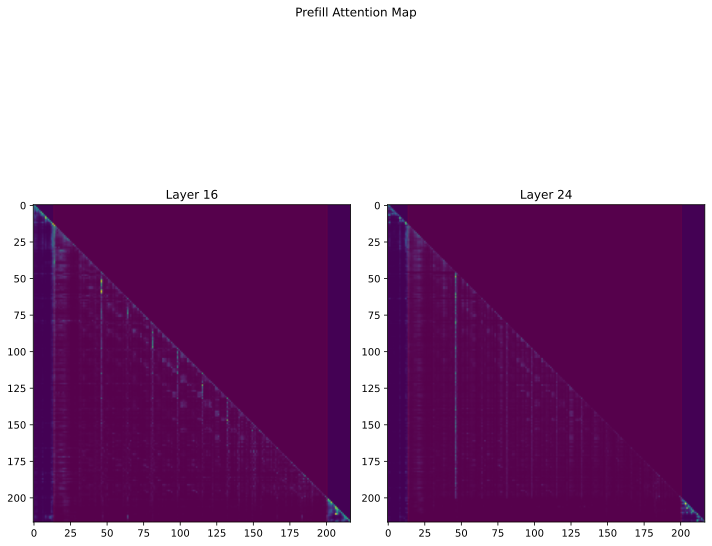

In [14]:
fig, axes = plt.subplots(1, len(out_attns), figsize=(10, 10))

for i, (layer_idx, out_attn) in enumerate(out_attns.items()):
    ax = axes[i] if len(out_attns) > 1 else axes
    im = ax.imshow(out_attn[0][0].mean(dim=0)[1:, 1:].float().numpy(), cmap="viridis")
    ax.axvspan(v_start - 1.5, v_end - 1.5, color="red", alpha=0.1)
    ax.set_title(f"Layer {layer_idx}")
plt.suptitle("Prefill Attention Map")
plt.tight_layout()
plt.show()


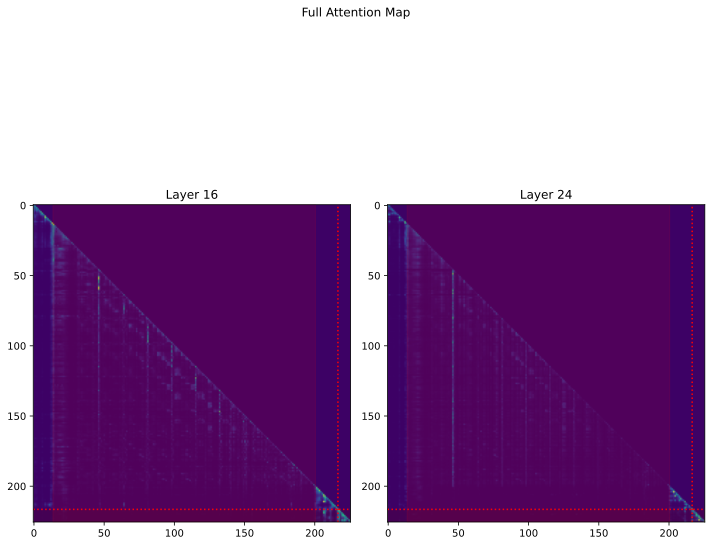

In [15]:
fig, axes = plt.subplots(1, len(out_attns), figsize=(10, 10))

for i, (layer_idx, merged_attn) in enumerate(merged_attns.items()):
    # print(merged_attn.shape)
    ax = axes[i] if len(merged_attns) > 1 else axes
    im = ax.imshow(merged_attn[0].mean(dim=0)[1:, 1:].float().numpy(), cmap="viridis")
    ax.axhspan(-0.5, inputs.input_ids.shape[1] - 1.5, color="blue", alpha=0.1)
    ax.axvspan(v_start - 1.5, v_end - 1.5, color="red", alpha=0.1)
    ax.axhline(inputs.input_ids.shape[1] - 1.5, color="red", linestyle=":")
    ax.axvline(inputs.input_ids.shape[1] - 1.5, color="red", linestyle=":")
    ax.set_title(f"Layer {layer_idx}")
    # plt.colorbar(im, ax=ax)
plt.suptitle("Full Attention Map")
plt.tight_layout()
plt.show()


Token 0: There
Entropy of layer 16: 4.6919965744018555
Entropy of layer 24: 4.046114444732666
Token 1:  are
Entropy of layer 16: 4.728710174560547
Entropy of layer 24: 4.468683242797852
Token 2:  two
Entropy of layer 16: 4.848372936248779
Entropy of layer 24: 4.391283988952637
Token 3:  green
Entropy of layer 16: 4.98607063293457
Entropy of layer 24: 4.525177001953125
Token 4:  objects
Entropy of layer 16: 4.917246341705322
Entropy of layer 24: 4.282055377960205
Token 5:  in
Entropy of layer 16: 4.753963470458984
Entropy of layer 24: 4.604605197906494
Token 6:  the
Entropy of layer 16: 4.114781379699707
Entropy of layer 24: 4.525580406188965
Token 7:  image
Entropy of layer 16: 4.09027099609375
Entropy of layer 24: 4.453651428222656
Token 8: .
Entropy of layer 16: 4.619340896606445
Entropy of layer 24: 4.102038860321045
Token 9: <|im_end|>
Entropy of layer 16: 4.750399589538574
Entropy of layer 24: 3.5296850204467773


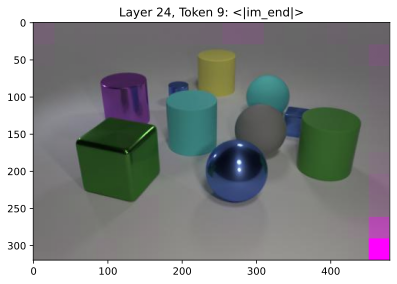

In [16]:
# Calculate number of tokens to visualize
num_tokens = output["sequences"].shape[1] - len(inputs.input_ids.flatten())
num_layers = len(out_attns.keys())
total_figures = num_tokens * num_layers

# Create a reasonable grid layout
rows = total_figures // 8
cols = 8

# fig, axes = plt.subplots(nrows=rows, ncols=cols)
# if rows == 1 and cols == 1:
#     axes = np.array([axes])  # Handle single subplot case
# axes = axes.flatten()

# Initialize plot index
i = 0
token_offset = len(inputs.input_ids.flatten())

# Loop through each generated token
for token_index in range(num_tokens):
    # Get the actual token index in the sequence
    seq_token_idx = token_index + token_offset

    # Print the token being visualized
    if seq_token_idx < len(output["sequences"][0]):
        token_text = processor.decode(output["sequences"][0][seq_token_idx])
        print(f"Token {token_index}: {token_text}")

    # Visualize attention for each layer
    for layer_idx, attn in merged_attns.items():
        try:
            # Create attention heatmap
            attention_map = (
                attn[0]
                .mean(dim=0)
                [seq_token_idx - 1, v_start:v_end]
                .reshape(h, w)
                .cpu()
                .float()
                .numpy()
            )

            # Calculate the entropy of the attention map
            normalized_attention_map = (attention_map / np.sum(attention_map)).ravel()
            entropy = -np.sum(normalized_attention_map * np.log(normalized_attention_map + 1e-10))
            print(f"Entropy of layer {layer_idx}: {entropy}")

            # Upsample the attention map to match the image size
            attention_map = cv2.resize(
                attention_map,
                (image.width, image.height),
                interpolation=cv2.INTER_NEAREST,
            )

            # Plot the image
            plt.imshow(image)

            # Overlay the attention map with transparency
            plt.imshow(attention_map, cmap=cm)
            
            # Disable the axis
            # plt.axis("off")
            plt.title(f"Layer {layer_idx}, Token {token_index}: {token_text}")
            plt.savefig(f"attn_maps/attention_map_{layer_idx}_{token_index}.png")

        except:
            pass

        i += 1

# Hide unused subplots
# for j in range(i, len(axes)):
#     axes[j].axis("off")

# plt.savefig("attention_maps.svg")
# plt.tight_layout()
# plt.show()


In [25]:
[out_attn.__len__() for out_attn in out_attns.values()]


[1, 1]

In [ ]:
len(out_attns[5])


KeyError: 5

: 

In [17]:
v_start, v_end = inputs.input_ids.flatten().tolist().index(processor.tokenizer.added_tokens_encoder["<|vision_start|>"])+1, inputs.input_ids.flatten().tolist().index(processor.tokenizer.added_tokens_encoder["<|vision_end|>"])
_, h, w = inputs.image_grid_thw[0] // 2

for attn_high, attn_low in zip(out_attns[5], out_attns[14], strict=True):
  # Visualize the attention maps
  
  # Visualize attn_high
  # Create a figure with two subplots side by side
  fig, axes = plt.subplots(2, 2, figsize=(10, 8))
  
  # Plot high layer attention map
  im1 = axes[0, 0].imshow(attn_high.mean(dim=(0,1))[-1, v_start:v_end].reshape(h, w).float().numpy(), cmap='viridis')
  axes[0, 0].set_title('High Layer Attention Map')
  axes[0, 0].set_xlabel('Token Index (Target)')
  axes[0, 0].set_ylabel('Token Index (Source)')
  fig.colorbar(im1, ax=axes[0, 0], label='Attention Weight')
  im1.set_clim(0, 0.05)
  
  # Plot low layer attention map
  im2 = axes[0, 1].imshow(attn_low.mean(dim=(0,1))[-1, v_start:v_end].reshape(h, w).float().numpy(), cmap='viridis')
  axes[0, 1].set_title('Low Layer Attention Map')
  axes[0, 1].set_xlabel('Token Index (Target)')
  axes[0, 1].set_ylabel('Token Index (Source)')
  fig.colorbar(im2, ax=axes[0, 1], label='Attention Weight')
  im2.set_clim(0, 0.05)

  # Plot difference between high and low layer attention maps
  im3 = axes[1, 0].imshow((attn_high - attn_low).mean(dim=(0,1)).exp().float().numpy()[:, 1:], cmap='viridis')
  axes[1, 0].set_title('Difference between High and Low Layer Attention Maps')
  axes[1, 0].set_xlabel('Token Index (Target)')
  axes[1, 0].set_ylabel('Token Index (Source)')
  fig.colorbar(im3, ax=axes[1, 0], label='Attention Weight')
  
  
  plt.tight_layout()
  # plt.figure(figsize=(10, 8))
  # print((attn_high - attn_low).mean(dim=(0,1)).float().numpy())
  # plt.imshow(attn_high.mean(dim=(0,1)).float().numpy()[:, 1:], cmap='viridis')
  # plt.colorbar(label='Attention Weight')
  # plt.title('High Layer Attention Map')
  # plt.xlabel('Token Index (Target)')
  # plt.ylabel('Token Index (Source)')
  # # Set the colorbar range from 0 to 0.3
  # plt.clim(0, 0.05)
  # plt.tight_layout()
  plt.show()


KeyError: 5

In [48]:
v_end - v_start - 1


666

In [38]:
processor.tokenizer.added_tokens_decoder


{151643: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151644: AddedToken("<|im_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151645: AddedToken("<|im_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151646: AddedToken("<|object_ref_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151647: AddedToken("<|object_ref_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151648: AddedToken("<|box_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151649: AddedToken("<|box_end|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151650: AddedToken("<|quad_start|>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
 151651: AddedToken("<|quad_end|>", rstrip=False, lstrip=